<h1>Прогнозирование объемов потребления электроэнергии<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Используемые-ресурсы" data-toc-modified-id="Используемые-ресурсы-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Используемые ресурсы</a></span></li><li><span><a href="#Выгрузка-базы-данных" data-toc-modified-id="Выгрузка-базы-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Выгрузка базы данных</a></span></li><li><span><a href="#Подготовка-обучающего,-тестового-и-валидационного-фреймов" data-toc-modified-id="Подготовка-обучающего,-тестового-и-валидационного-фреймов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка обучающего, тестового и валидационного фреймов</a></span></li><li><span><a href="#Анализ-структуры-исходных-данных" data-toc-modified-id="Анализ-структуры-исходных-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ структуры исходных данных</a></span></li><li><span><a href="#Корреляция-числовых-и-категориальных-признаков" data-toc-modified-id="Корреляция-числовых-и-категориальных-признаков-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Корреляция числовых и категориальных признаков</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>XGBoost</a></span><ul class="toc-item"><li><span><a href="#Оценка-ценности-признаков" data-toc-modified-id="Оценка-ценности-признаков-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Оценка ценности признаков</a></span></li><li><span><a href="#Обучение-на-потерях-тестовых-данных-при-кросс-валидации-генеральной-совокупности" data-toc-modified-id="Обучение-на-потерях-тестовых-данных-при-кросс-валидации-генеральной-совокупности-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Обучение на потерях тестовых данных при кросс-валидации генеральной совокупности</a></span><ul class="toc-item"><li><span><a href="#Валидация-(грубая)-модели-на-новых-данных-(январь-2024)" data-toc-modified-id="Валидация-(грубая)-модели-на-новых-данных-(январь-2024)-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Валидация (грубая) модели на новых данных (январь 2024)</a></span></li></ul></li><li><span><a href="#Обучение-с-фильтрацией-исходных-признаков-и-временного-диапазона" data-toc-modified-id="Обучение-с-фильтрацией-исходных-признаков-и-временного-диапазона-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Обучение с фильтрацией исходных признаков и временного диапазона</a></span><ul class="toc-item"><li><span><a href="#Валидация-модели-на-старых-данных-(2023)" data-toc-modified-id="Валидация-модели-на-старых-данных-(2023)-6.3.1"><span class="toc-item-num">6.3.1&nbsp;&nbsp;</span>Валидация модели на старых данных (2023)</a></span></li><li><span><a href="#Валидация-(грубая)-модели-на-новых-данных-(январь-2024)" data-toc-modified-id="Валидация-(грубая)-модели-на-новых-данных-(январь-2024)-6.3.2"><span class="toc-item-num">6.3.2&nbsp;&nbsp;</span>Валидация (грубая) модели на новых данных (январь 2024)</a></span></li></ul></li><li><span><a href="#Посуточное-обучение-и-валидация" data-toc-modified-id="Посуточное-обучение-и-валидация-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Посуточное обучение и валидация</a></span></li></ul></li></ul></div>

**Исследуемый субъект:** республика Татарстан. Генеральная совокупность: 01.04.2013 – 31.12.2023, тестовая выборка: 2023 год (09.01.2023 – 29.12.2023), валидационная выборка: 09.01.2024 – 29.02.2024

# Используемые ресурсы

In [46]:
import os
import re
import shutil
import requests
import datetime
import warnings
import pandas as pd
from bs4 import BeautifulSoup
from tqdm.notebook import trange

import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xgboost as xgb
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# Выгрузка базы данных

In [2]:
headers = {
    'Accept': '*/*',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36'
}

t = {'ё': 'yo', 'а': 'a', 'б': 'b', 'в': 'v', 'г': 'g', 'д': 'd', 'е': 'e', 'ж': 'zh',
     'з': 'z', 'и': 'i', 'й': 'y', 'к': 'k', 'л': 'l', 'м': 'm', 'н': 'n', 'о': 'o', 'п': 'p',
     'р': 'r', 'с': 's', 'т': 't', 'у': 'u', 'ф': 'f', 'х': 'h', 'ц': 'c', 'ч': 'ch', 'ш': 'sh',
     'щ': 'shch', 'ъ': '', 'ы': 'y', 'ь': '', 'э': 'e', 'ю': 'yu', 'я': 'ya'}


def translate(text: str, sep='_'):
    tx = ''
    for i in text:
        if i != ' ':
            tx += t.get(i, i)
        else:
            tx += sep
    return tx


valid_data = {}
with open('index.html', 'r', encoding='utf-8') as file:
    src = file.read()

soup = BeautifulSoup(src, 'html.parser')
anch = soup.find_all('a')

for item in anch:
    valid_data[item.text] = item.get('href')[item.get(
        'href').find('_', 36)+1:item.get('href').rfind('_')-5]


def get_data():
    #key = input('\n'.join(valid_data.keys()) + '\n')
    key = 'Республика Татарстан'
    tr_key = translate(key.lower())
    if not os.path.exists(f'./{tr_key.capitalize()}'):
        os.mkdir(f'./{tr_key.capitalize()}')
    for i in range(2013, datetime.now().year + 1):
        for j in range(1, 13):
            req = requests.get(
                url=f'https://www.atsenergo.ru/dload/fact_region/{i}{j:02}01/{i}{j:02}01_{valid_data[key]}_fact_region.xls',
                headers=headers,
                verify=False
            )
            if req.status_code == 404:
                continue
            try:
                if not os.path.exists(f'./{tr_key.capitalize()}/{tr_key}_{i}_{j:02}__{valid_data[key]}.xls'):
                    with open(f'./{tr_key.capitalize()}/{tr_key}_{i}_{j:02}__{valid_data[key]}.xls', 'wb') as file:
                        file.write(req.content)
            except Exception as ex:
                print(ex)
    return transformation_data(tr_key)


def transformation_data(key):
    for adress, dirs, files in os.walk(f'./{key.capitalize()}'):
        for name in files:
            url = os.path.join(adress, name)
            df = pd.read_excel(url, index_col=False)
            if pd.isna(df.iloc[-1, 1]):
                df = df.iloc[6:-2]
            else:
                df = df.iloc[6:]
            df.columns = ['Date', 'Hour', 'Volume']
            df = df.reset_index(drop=True)
            df['Date'] = df['Date'].apply(lambda x: x.replace('.', '-'))
            df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
            for i, j in enumerate(['Year', 'Month', 'Day']):
                if j == 'Year':
                    df.insert(i, j, df['Date'].dt.year)
                elif j == 'Month':
                    df.insert(i, j, df['Date'].dt.month)
                else:
                    df.insert(i, j, df['Date'].dt.day)
            df = df.drop(columns='Date')
            df.to_excel(url+'x', index=False)
            os.remove(url)
    return result_dataframe(key)


def result_dataframe(key):
    files_url = []
    result = pd.DataFrame()
    for adress, dirs, files in os.walk(f'./{key.capitalize()}'):
        for name in files:
            files_url.append(os.path.join(adress, name))
    for file in files_url:
        df = pd.read_excel(file, index_col=False)
        result = result._append(df)
    shutil.rmtree(f'./{key.capitalize()}')
    return result

In [3]:
warnings.filterwarnings('ignore') # супрессим предупреждения https

df = get_data()

warnings.filterwarnings("default") # возвращаем предупреждения к дефолтным настройкам

In [3]:
df

,Year,Month,Day,Hour,Volume
0,2013,4,1,1,2814.717
1,2013,4,1,2,2747.458
2,2013,4,1,3,2734.133
3,2013,4,1,4,2736.587
4,2013,4,1,5,2796.396
...,...,...,...,...,...
64339,2024,2,29,20,4077.238
64340,2024,2,29,21,4038.878
64341,2024,2,29,22,3932.423
64342,2024,2,29,23,3775.152


In [5]:
# Модуль погоды для Татарстана
months = ['январь', 'февраль', 'март', 'апрель', 'май', 'июнь',
                   'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь']
links = []
data_of_weather = []

for month in months:
    req = requests.get(url=f'https://kazan.nuipogoda.ru/{month}-2011')
    soup = BeautifulSoup(req.content, 'lxml')
    all_tds = soup.find_all('td')
    for i in range(len(all_tds)):
        try:
            links.append('https://kazan.nuipogoda.ru/' + all_tds[i].find('a').get('href'))
        except AttributeError:
            continue

for j in links:
    req=requests.get(url=j)
    soup=BeautifulSoup(req.content)
    trs = soup.find_all('tr', time=re.compile(r'[0-9]'))
    for k in range(len(trs)):
        data_of_weather.append((list(trs[k].attrs.values())[0], trs[k].find('span', class_='ht').text[:-1]))
        
df_weather = pd.DataFrame(data_of_weather, columns=['Time', 'Temperature']).astype('int64')
df_weather['Time'] = pd.to_datetime(df_weather['Time'], unit='ms')
df_weather['Year'] = df_weather['Time'].dt.year
df_weather['Month'] = df_weather['Time'].dt.month
df_weather['Day'] = df_weather['Time'].dt.day
df_weather['Hour'] = df_weather['Time'].dt.hour
df_weather = df_weather.loc[(df_weather['Hour'] != 0)].reset_index(drop=True)
df_weather.drop(columns='Time', inplace=True)
df_weather = df_weather[['Year', 'Month', 'Day', 'Hour', 'Temperature']]

In [4]:
df_weather

,Year,Month,Day,Hour,Temperature
0,2024,1,1,3,-11
1,2024,1,1,6,-10
2,2024,1,1,9,-13
3,2024,1,1,12,-15
4,2024,1,1,15,-18
...,...,...,...,...,...
38164,2010,12,31,9,-6
38165,2010,12,31,12,-6
38166,2010,12,31,15,-5
38167,2010,12,31,18,-2


In [47]:
#df.to_excel('Tatarstan.xlsx')
#df_weather.to_excel('Weather_Tatarstan.xlsx')

# работа с готовой базой без использования интернета 
df = pd.read_excel('Tatarstan.xlsx')
df = df [['Year', 'Month', 'Day', 'Hour', 'Volume']]
df_weather = pd.read_excel('Weather_Tatarstan.xlsx')
df_weather = df_weather[['Year', 'Month', 'Day', 'Hour', 'Temperature']]

# Подготовка обучающего, тестового и валидационного фреймов

In [48]:
# добавляем новые признаки (интервал 1-5 т.к. отсутствуют сб и вск)
def prepareData(df, df_weather, lag_start = 1, lag_end = 5):
    
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    df['Weekday'] = df['date'].dt.weekday  # добавляем день недели
    #df = df[df['Weekday'] != 5]  # убираем случайные данные за субботу
        
    df = df.merge(df_weather, how='left', on=['Year', 'Month', 'Day', 'Hour'])  # добавляем погодный признак
    
    # удаляем возможные дубликаты
    df = df.drop_duplicates(subset=['Year', 'Month', 'Day', 'Hour', 'Temperature'])
    
    # интерполируем пропуски (линейная, полиноминальная 2 порядка)
    df['Temperature'] = df['Temperature'].interpolate(method='polynomial', order=2).round(1)
    #df = df.fillna(-6.5)  # доработать экстраполяцию (усредненное значение за сутки)
     
    df = df[['Year', 'Month', 'Day', 'Hour', 'Weekday', 'Temperature', 'Volume']]  # упорядочиваем столбцы
        
    # добавляем суточные лаги исходного ряда
    for i in range(lag_start, lag_end + 1): # (интервал 1-5 т.к. отсутствуют сб и вск)
        df[f"lag-{i}"] = df.Volume.shift(i*24)
    
    df = df.dropna()
    df.reset_index(drop=True, inplace=True)
    
    return df

In [49]:
# формируем генеральную совокупность
df_general = df.copy()

# добавляем новые признаки
df_general = prepareData(df_general, df_weather)

# формируем обучающий датафрейм
df_train = df_general[df_general['Year'] < datetime.now().year - 1]

# формируем тестовую выборку
df_test = df_general[df_general['Year'] == datetime.now().year - 1]
df_test.reset_index(drop=True, inplace=True)

# формируем валидационную выборку
df_validate = df_general[df_general['Year'] == datetime.now().year]
df_validate.reset_index(drop=True, inplace=True)

# исключаем валидационную выборку из генеральной совокупности
df_general = df_general[df_general['Year'] < datetime.now().year]

# дни недели в рассматриваемой геенральной совокупности
df_general.Weekday.unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

In [50]:
#df_general.to_excel('Tatarstan.xlsx')
df_general

,Year,Month,Day,Hour,Weekday,Temperature,Volume,lag-1,lag-2,lag-3,lag-4,lag-5
0,2013,4,8,1,0,1.9,2622.054,2884.190,2853.500,2882.216,2907.082,2814.717
1,2013,4,8,2,0,1.0,2563.115,2804.228,2810.466,2827.057,2850.464,2747.458
2,2013,4,8,3,0,0.7,2539.006,2794.442,2786.895,2797.725,2803.600,2734.133
3,2013,4,8,4,0,0.8,2553.500,2789.910,2785.731,2780.183,2826.062,2736.587
4,2013,4,8,5,0,1.0,2584.990,2800.015,2787.218,2797.009,2834.545,2796.396
...,...,...,...,...,...,...,...,...,...,...,...,...
63331,2023,12,29,20,4,-8.3,3675.452,3752.951,3744.271,3760.425,3795.803,3754.031
63332,2023,12,29,21,4,-9.0,3653.876,3710.579,3715.376,3720.578,3750.715,3718.243
63333,2023,12,29,22,4,-10.4,3598.927,3639.774,3643.383,3647.386,3637.997,3672.833
63334,2023,12,29,23,4,-12.5,3475.832,3544.844,3500.565,3525.623,3678.852,3541.584


# Анализ структуры исходных данных

*График структуры (усредненной по дням недели) потребления электрической энергии за 10 лет*

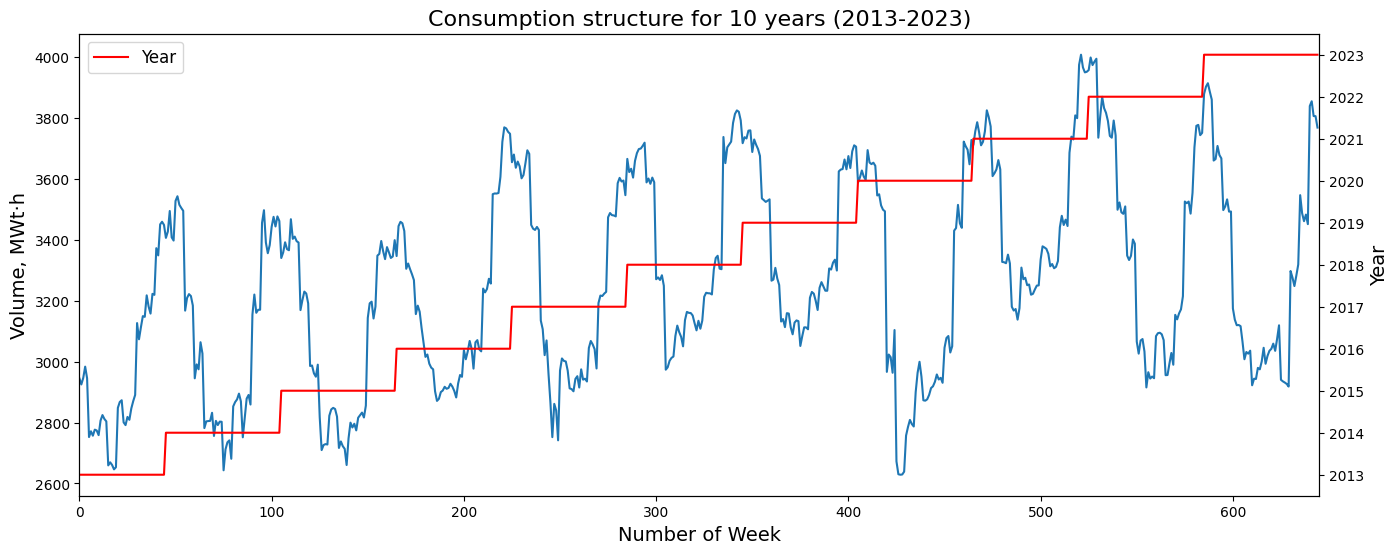

In [23]:
df_general_group = df_general.groupby(['Year', 'Month', 'Weekday'])[['Volume']].mean()
df_general_group.reset_index(inplace=True)
#df_general_group = df_general.copy()  # разблокировать при необходимости отмены группировки параметров

fig, df_volume = plt.subplots(figsize=(16,6))
df_year = df_volume.twinx()

df_volume.plot(df_general_group['Volume'], label='Volume')
df_year.plot(df_general_group['Year'], label='Year', color='red')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(0, df_general_group.shape[0])
#df_volume.set_ylim(df_general_group['Volume'].min(), df_general_group['Volume'].max())  # диапазон 'volume' от min до max
df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
df_volume.set_xlabel('Number of Week', fontsize = 14)
df_year.set_ylabel('Year', fontsize = 14)
df_year.yaxis.set_major_locator(ticker.MultipleLocator(1.00))

plt.title(f'Сonsumption structure for 10 years (2013-{datetime.now().year-1})', fontsize = 16)
plt.legend()

*График структуры (усредненной по дням) потребления электрической энергии за 2023 год*

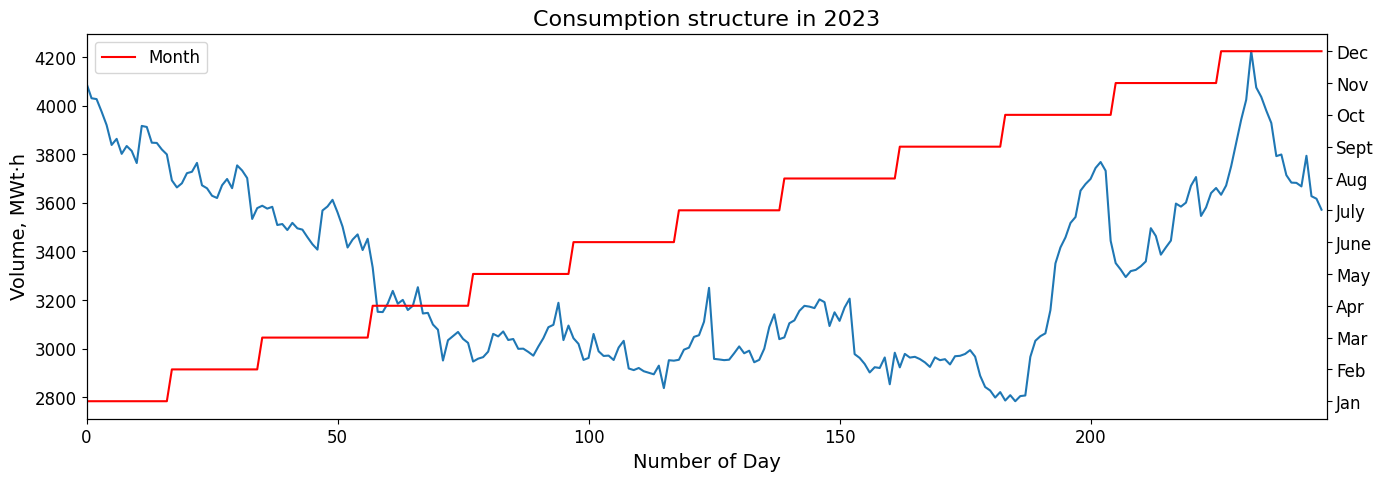

In [24]:
df_last_year = df_general[df_general['Year'] == datetime.now().year - 1]
df_last_year.reset_index(drop=True, inplace=True)

df_group_last_year = df_last_year.groupby(['Month', 'Day'])[['Volume']].mean()
df_group_last_year.reset_index(inplace=True)
#df_group_last_year = df_last_year.copy()  # разблокировать при необходимости отмены группировки параметров

fig, df_volume = plt.subplots(figsize=(16,5))
df_month = df_volume.twinx()

df_volume.plot(df_group_last_year['Volume'], label='Volume')
df_month.plot(df_group_last_year['Month'], label='Month', color='r')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(0, df_group_last_year.shape[0])
df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
df_volume.set_xlabel('Number of Day', fontsize = 14)
df_month.yaxis.set_major_locator(ticker.FixedLocator([i for i in range(1, 13)]))
df_month.yaxis.set_major_formatter(ticker.FixedFormatter(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']))

plt.title(f'Сonsumption structure in {datetime.now().year-1}', fontsize = 16)
plt.legend()

*График зависимости усреднённой по дням температуры с усреднённым по дням потреблением ЭЭ для 2023 года*

Text(0.5, 1.0, 'Graph of average daily consumption and average daily temperature for 2023')

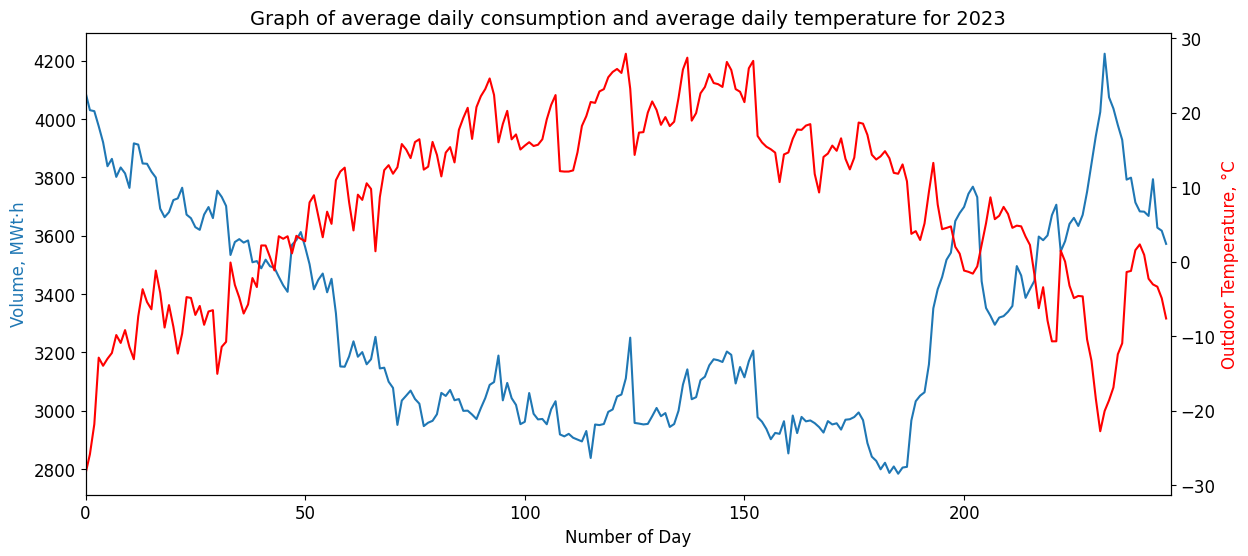

In [25]:
df_group_last_year = df_last_year.groupby(['Month', 'Day'])[['Volume', 'Temperature']].mean()
df_group_last_year.reset_index(drop=True, inplace=True) 

fig, df_volume = plt.subplots(figsize=(14,6))
df_temperature = df_volume.twinx()

df_volume.plot(df_group_last_year['Volume'], color='#1f77b4', label='Volume')

df_temperature.plot(df_group_last_year['Temperature'], color = 'red', label = 'Temperature')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(0, df_group_last_year.shape[0])
df_volume.set_ylabel('Volume, MWt·h', fontsize = 12, color='#1f77b4')
df_volume.set_xlabel('Number of Day', fontsize = 12)
df_temperature.set_ylabel('Outdoor Temperature, °C', fontsize = 12, color='red')

plt.title(f'Graph of average daily consumption and average daily temperature for {datetime.now().year-1}', fontsize = 14)

**Вывод**: Наблюдается отчетливая корреляция между температурой наружного воздуха и объемом электропотребления

**Примечание**: 247 строк вместо 365, поскольку нет данных по выходным и празничным дням

*График структуры потребления электрической энергии по дням недели в течении месяца*

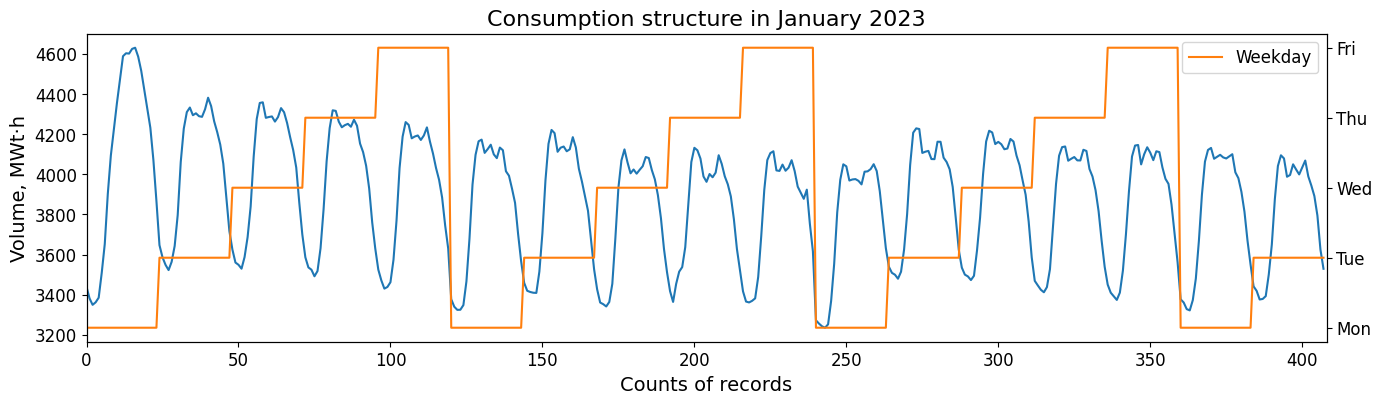

In [52]:
month = list(name for name in calendar.month_name)

df_month = df_test[df_test['Month'] == 1]  # указываем интересующий нас месяц
df_month.reset_index(drop=True, inplace=True)

fig, df_volume = plt.subplots(figsize=(16,4))
df_weekday = df_volume.twinx()

df_volume.plot(df_month['Volume'], label='Volume')
df_weekday.plot(df_month['Weekday'], label='Weekday', color='#ff7f0e')

plt.rcParams['font.size'] = '12'

df_volume.set_xlim(0, df_month.shape[0])
df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
df_volume.set_xlabel('Counts of records', fontsize = 14)
df_weekday.yaxis.set_major_locator(ticker.FixedLocator([0, 1, 2, 3, 4, 5, 6]))
df_weekday.yaxis.set_major_formatter(ticker.FixedFormatter(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']))

plt.title(f'Сonsumption structure in {month[df_month.Month[0]]} {datetime.now().year-1}', fontsize = 16)
plt.legend()

# Корреляция числовых и категориальных признаков

In [27]:
# корреляция исходных значений и целевого признака
color_map = sns.color_palette("vlag", as_cmap=True)

df_gen = df_general[['Year', 'Month', 'Day', 'Hour', 'Temperature', 'Volume']]

df_gen.corr('pearson').style.background_gradient(cmap=color_map, vmin = -1, vmax=1)

,Year,Month,Day,Hour,Temperature,Volume
Year,1.000000,-0.048321,-0.004465,0.000000,-0.022922,0.284924
Month,-0.048321,1.000000,-0.043426,0.000000,0.108872,-0.028867
Day,-0.004465,-0.043426,1.000000,-0.000000,-0.034313,0.015316
Hour,0.000000,0.000000,-0.000000,1.000000,0.061400,0.341902
Temperature,-0.022922,0.108872,-0.034313,0.061400,1.000000,-0.535320
Volume,0.284924,-0.028867,0.015316,0.341902,-0.535320,1.000000


**Вывод**: ощутимая корреляционная связь объема с годом, часом и температурой

# XGBoost

## Оценка ценности признаков

In [60]:
# классификация ценности признаков в контексте регрессора XGBoost
selector = xgb.XGBRegressor(random_state=10)
result = selector.fit(df_general.drop(columns='Volume'), df_general['Volume'])

features_table = pd.DataFrame(result.feature_importances_, 
                              index = df_general.drop(columns='Volume').columns, 
                              columns = ['importance'])

features_table.sort_values(by='importance', ascending=False).T

,lag-1,lag-2,lag-3,lag-5,Temperature,Month,Weekday,lag-4,Day,Year,Hour
importance,0.829905,0.107761,0.024407,0.013562,0.004731,0.004188,0.004008,0.003012,0.002841,0.002803,0.002781


In [61]:
# исследуемый список датасетов с учетом ценности признаков
dataset = list([df_general.drop(columns='Volume').columns,
                df_general.drop(columns=['Hour', 'Volume']).columns,
                df_general.drop(columns=['Hour', 'Year', 'Volume']).columns])

predictions = list(['Predicted',  # скорректировать список под новые данные при изменении ценности признаков
                    'Predicted_1c', 
                    'Predicted_2c'])

messages = list(['Full set:            ',
                 'Without Hour:       ',
                 'Without Hour & Year:'])

## Обучение на потерях тестовых данных при кросс-валидации генеральной совокупности
Обучение выполняется по методике, описанной в [статье](https://www.mdpi.com/2411-5134/8/5/114): валидация 1 к 3, количество деревьев `n_estimators` – 100, генеральная совокупность данных – за 3 года

In [62]:
%%time

# поиск лучших гиперпараметров XGBoost с помощью сетки гиперпараметров
df_boost_train = df_general[df_general['Year'] > 2020]  # формируем обучающий датафрейм
df_boost_test = df_test.copy()

XGB_search = GridSearchCV(estimator=xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators = 100), 
                          param_grid={'max_depth': range(2, 10)}, 
                          scoring='neg_mean_absolute_percentage_error', 
                          verbose = 0,
                          cv=3)

XGB_search.fit(df_boost_train.drop(columns='Volume'), df_boost_train['Volume'])

XGB_best = XGB_search.best_estimator_

XGB_best.fit(df_boost_train.drop(columns='Volume'), df_boost_train['Volume'])

# Предсказываем объемы потребления
df_boost_test['Predicted'] = XGB_best.predict(df_boost_test.drop(columns='Volume'))

# Метрики качества прогноза
print('MAE:', f"{MAE(df_boost_test['Predicted'], df_boost_test['Volume']):.2f} [MW]",
      '\nMAPE:', f"{MAPE(df_boost_test['Predicted'], df_boost_test['Volume']):.2%}")

hyper_params = XGB_best.get_params()
print(f"max_depth: {hyper_params['max_depth']}, n_estimators: {hyper_params['n_estimators']}")

print()

MAE: 52.41 [MW] 
MAPE: 1.58%
max_depth: 2, n_estimators: 100

CPU times: total: 32.8 s
Wall time: 10.6 s


### Валидация (грубая) модели на новых данных (январь 2024)
*Прогнозирование на месяц вперед*

In [63]:
# Грубая валидация без сокрытия данных на текущие сутки (для скоростной проверки гипотезы)

df_boost_test = df_validate.copy()

df_boost_test['Predicted'] = XGB_best.predict(df_boost_test.drop(columns='Volume'))

# Метрики качества прогноза
print('MAE:', f"{MAE(df_boost_test['Predicted'], df_boost_test['Volume']):.2f} [MW]",
      '\nMAPE:', f"{MAPE(df_boost_test['Predicted'], df_boost_test['Volume']):.2%}")

#df_boost_test

MAE: 68.51 [MW] 
MAPE: 1.77%


## Обучение с фильтрацией исходных признаков и временного диапазона

In [64]:
%%time

# инициализируем итоговый датафрейм по всем временным интервалам (3-11 лет)
df_general_result = pd.DataFrame({'period':[],  # рассматриваемый временной интервал
                                  'set': [],  # тип датасета
                                  'MAE [MW]':[],  # минимальная средняя абсолютная ошибка
                                  'MAPE':[],  # минимальная средняя относительная ошибка
                                  'max_depth':[],  # оптимальная глубина дерева
                                  'n_estimators':[]})  # оптимальное количество деревьев

index = 0  # индекс узла сетки итогового датафрейма

df_boost_test = df_test.copy()

for time in trange(2021, 2012, -1, desc=f"period progress"):  # виджет процесса расчёта оптимальных гиперпараметров

    df_boost_train = df_general[df_general['Year'] >= time]  # формируем обучающий датафрейм под рассматриваемый интервал

    for data in range(len(dataset)):  # выбор датасета

        XGB_search = GridSearchCV(estimator=xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators = 100), 
                          param_grid={'max_depth': range(2, 8)}, 
                          scoring='neg_mean_absolute_percentage_error',
                          verbose = 0,
                          cv=5)

        XGB_search.fit(df_boost_train[dataset[data]], df_boost_train['Volume'].values)

        XGB_best = XGB_search.best_estimator_

        XGB_best.fit(df_boost_train[dataset[data]], df_boost_train['Volume'].values)
        
        df_boost_test[predictions[data]] = XGB_best.predict(df_boost_test[dataset[data]])
        
        hyper_params = XGB_best.get_params()

        # заполняем итоговый датафрейм лучшим результатом для данной выборки
        df_general_result.loc[index] = (2024 - time, messages[data], 
                                        MAE(df_boost_test[predictions[data]], df_boost_test['Volume']), 
                                        MAPE(df_boost_test[predictions[data]], df_boost_test['Volume']),
                                        hyper_params['max_depth'],
                                        hyper_params['n_estimators'])
        index += 1;

#print()

period progress:   0%|          | 0/9 [00:00<?, ?it/s]

CPU times: total: 19min 19s
Wall time: 4min 58s


*Полученная комбинация оптимальных гиперпараметров при различной глубине временного интервала заданных датасетов*

In [65]:
i = df_general_result.MAPE.idxmin()  # позиция df_general_result с лучшим результатом

best_HP = {'period': df_general_result.period[i],   # оптимальный временной период
            'index': messages.index(df_general_result.set[i]),  # индекс оптимального датасета
            'max_depth': df_general_result.max_depth[i],   # отпимальная глубина дерева
            'n_estimators': df_general_result.n_estimators[i]}  # оптимальное колличество деревьев

print(best_HP)

df_general_result.style.highlight_min(color='yellowgreen', subset='MAPE')

{'period': 5, 'index': 0, 'max_depth': 7, 'n_estimators': 100}


,period,set,MAE [MW],MAPE,max_depth,n_estimators
0,3,Full set:,52.406442,0.015826,2,100
1,3,Without Hour:,53.364823,0.016161,2,100
2,3,Without Hour & Year:,52.996208,0.016023,2,100
3,4,Full set:,52.021949,0.015712,2,100
4,4,Without Hour:,48.199500,0.014644,3,100
5,4,Without Hour & Year:,47.696268,0.014467,3,100
6,5,Full set:,22.104978,0.006770,7,100
7,5,Without Hour:,47.591208,0.014462,3,100
8,5,Without Hour & Year:,47.997101,0.014553,3,100
9,6,Full set:,47.293665,0.014364,3,100


In [66]:
# ручная донастройка гиперпараметров
best_HP = {'period': 5,   # оптимальный временной период
            'index': 0,  # индекс оптимального датасета
            'max_depth': 3,   # отпимальная глубина дерева
            'n_estimators': 100}  # оптимальное колличество деревьев

*Предельные показатели метрики MAPE при различной глубине исследуемого интервала*

{'period': 5, 'index': 0, 'max_depth': 3, 'n_estimators': 100}


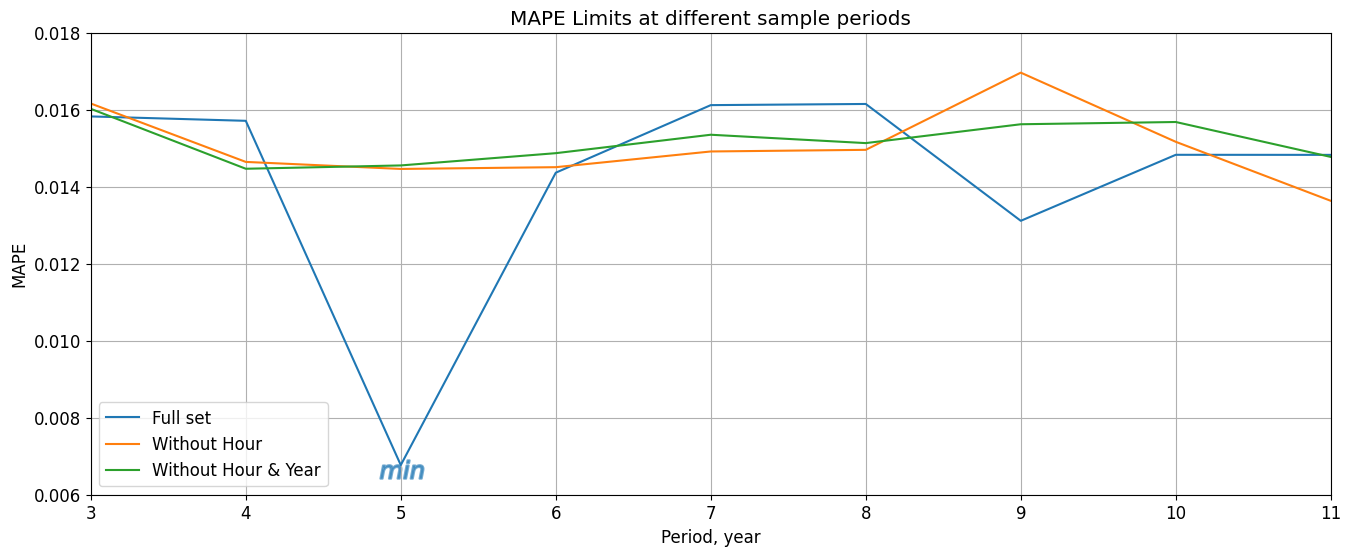

In [67]:
plot_gen = list()
for i in range(len(messages)):
    plot_gen.append(df_general_result[df_general_result['set'] == messages[i]])
    plot_gen[i]=plot_gen[i][['period', 'MAPE']]
    plot_gen[i].set_index('period', inplace= True)
    plot_gen[i] = plot_gen[i].rename(columns={'MAPE': messages[i].rstrip()[:-1]})

pd.concat([plot_gen[i] for i in range(3)], axis=1).plot(figsize=(16,6), 
                                                        title='MAPE Limits at different sample periods',
                                                        xlim=(df_general_result.period.min(), 
                                                              df_general_result.period.max()), 
                                                        ylim=(round(df_general_result.MAPE.min(), 3) - 0.001, 
                                                              round(df_general_result.MAPE.max(), 3) + 0.001),
                                                        xlabel='Period, year',
                                                        ylabel='MAPE',
                                                        legend=True,
                                                        grid=True)

plt.scatter(df_general_result.period[df_general_result.MAPE.idxmin()], 
            df_general_result.MAPE.min()-0.0001,
            linewidth=1.5,
            marker='$min$',
            alpha=0.6,
            s=1000)

print(best_HP)

**Выводы**: 
1. Фильтрация исходных признаков лишено всякого смысла
2. Оптимальный размер обучающей выборки: 5-6 лет
3. Оптимальная глубина дерева: 2-6 веток

### Валидация модели на старых данных (2023)

*Оценка прогнозирования за 2023 год при оптимальных гиперпараметрах с разбивкой по месяцам*

In [68]:
%%time

df_boost_test = df_test.copy()  # формируем тестовый датафрейм
df_boost_train = df_general[df_general['Year'] > datetime.now().year - best_HP['period'] - 1]  # формируем обучающий датафрейм

# обучаем модель
model = xgb.XGBRegressor(tree_method = 'gpu_hist', # включаем ранее найденные оптимальные гиперпараметры 
                         n_estimators = best_HP['n_estimators'],
                         max_depth = best_HP['max_depth'])

model.fit(df_boost_train[dataset[best_HP['index']]], df_boost_train['Volume'])
df_boost_test[predictions[best_HP['index']]] = model.predict(df_boost_test[dataset[best_HP['index']]])

CPU times: total: 1.14 s
Wall time: 272 ms


In [69]:
month = list(name for name in calendar.month_name)

df_month_result = pd.DataFrame({'Month':[],
                                'MAE [MW]':[],
                                'MAPE':[]})

for i in range(12):
    df_month = df_boost_test[df_boost_test['Month'] == i + 1]
    if df_month.shape[0]:
        df_month_result.loc[i] = (month[i + 1],
                                  f"{MAE(df_month[predictions[best_HP['index']]], df_month['Volume']):.2f}", 
                                  f"{MAPE(df_month[predictions[best_HP['index']]], df_month['Volume']):.3%}")

df_month_result = pd.concat([df_month_result, 
                             pd.DataFrame({'Month': 'Average', 
                                           'MAE [MW]': f"{MAE(df_boost_test[predictions[best_HP['index']]], df_boost_test['Volume']):.2f}", 
                                           'MAPE': f"{MAPE(df_boost_test[predictions[best_HP['index']]], df_boost_test['Volume']):.3%}"}, 
                             index = [0])])

df_month_result.set_index('Month').T

Month,January,February,March,April,May,June,July,August,September,October,November,December,Average
MAE [MW],47.27,46.12,45.09,46.36,44.34,44.35,41.92,44.78,33.84,60.97,49.68,52.17,46.45
MAPE,1.225%,1.254%,1.282%,1.474%,1.469%,1.484%,1.354%,1.448%,1.160%,1.875%,1.428%,1.385%,1.409%


### Валидация (грубая) модели на новых данных (январь 2024)
*Прогнозирование на месяц вперед*

In [70]:
# Предсказываем объемы потребления на валидационной выборке
df_validate_boost = df_validate.copy()

df_validate_boost[predictions[best_HP['index']]] = model.predict(df_validate_boost[dataset[best_HP['index']]])

# Метрики качества прогноза
print('MAE:', f"{MAE(df_validate_boost[predictions[best_HP['index']]], df_validate_boost['Volume']):.2f} [MW]",
      '\nMAPE:', f"{MAPE(df_validate_boost[predictions[best_HP['index']]], df_validate_boost['Volume']):.2%}")

df_validate_boost

MAE: 66.15 [MW] 
MAPE: 1.71%


,Year,Month,Day,Hour,Weekday,Temperature,Volume,lag-1,lag-2,lag-3,lag-4,lag-5,Predicted
0,2024,1,9,1,1,-18.1,3533.232,3299.268,3273.353,3258.593,3680.799,3278.413,3430.482666
1,2024,1,9,2,1,-20.0,3494.442,3247.317,3227.633,3231.546,3639.848,3218.436,3438.725342
2,2024,1,9,3,1,-21.0,3442.868,3214.234,3207.250,3197.980,3576.965,3193.126,3396.374268
3,2024,1,9,4,1,-21.2,3452.745,3171.144,3171.593,3175.354,3559.458,3166.955,3384.923584
4,2024,1,9,5,1,-20.7,3467.223,3211.753,3204.151,3204.701,3584.175,3188.801,3396.374268
...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,2024,2,28,17,2,-4.2,4058.485,4002.598,4131.749,4142.471,4039.860,4003.444,3999.653809
857,2024,2,28,18,2,-5.0,4143.907,4169.456,4236.134,4226.296,4117.864,4092.828,4133.803711
858,2024,2,28,19,2,-5.7,4180.211,4171.016,4233.081,4221.572,4077.823,4046.500,4126.888184
859,2024,2,28,20,2,-6.4,4145.836,4150.832,4176.959,4187.720,4041.151,3976.330,4111.719727


*Сравнение прогнозных значений с фактическими*

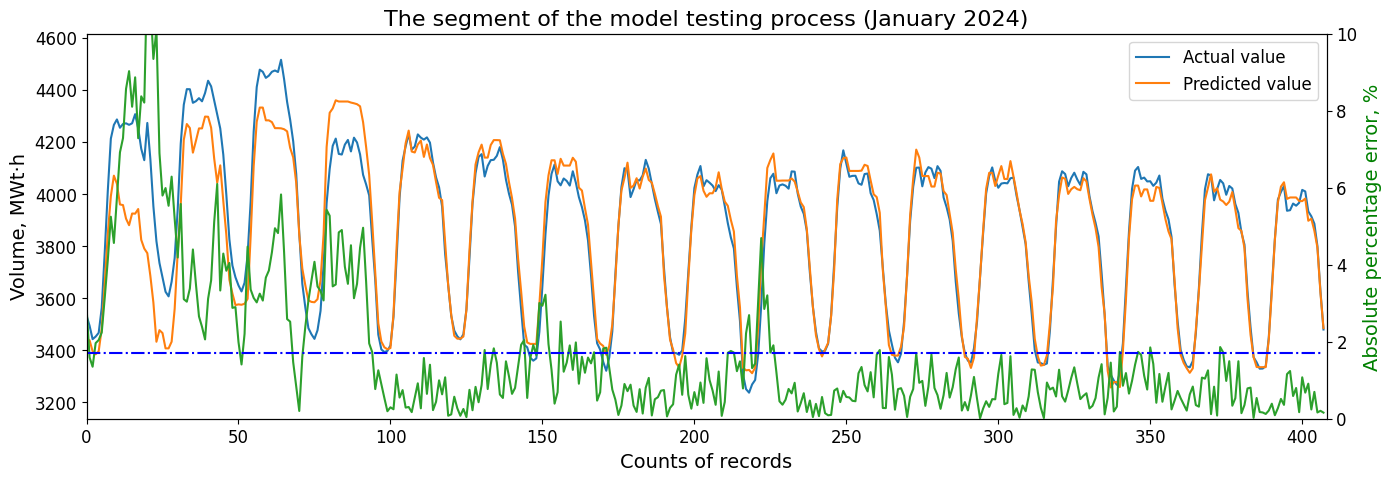

In [71]:
# приводим название столбца Prediction для фильтрованных данных к общему виду
df_validate_boost = df_validate_boost.rename(columns={predictions[best_HP['index']]:'Predicted'})

def diff_predict_vs_fact(df_validate_boost, num_month):
    
    df_validate_graph = df_validate_boost[df_validate_boost['Month'] == num_month].copy()

    # добавление новых столбцов (для расчёта усреднённой погрешности)
    df_validate_graph.insert(df_validate_graph.shape[1], 'MAPE', 
                             MAPE(df_validate_graph['Predicted'], df_validate_graph['Volume'])*100)

    df_validate_graph['Error'] = abs((df_validate_graph['Volume'] - df_validate_graph['Predicted'])*100
                                 /df_validate_graph['Volume'])

    df_validate_graph.reset_index(drop=True, inplace=True)

    fig, df_volume = plt.subplots(figsize=(16,5))
    df_error = df_volume.twinx()

    df_volume.plot(df_validate_graph['Volume'], label='Actual value')
    df_volume.plot(df_validate_graph['Predicted'], label='Predicted value')
    df_error.plot(df_validate_graph['Error'], label='Error, %', color='#2ca02c')
    df_error.plot(df_validate_graph['MAPE'], '-.b')

    plt.rcParams['font.size'] = '12'

    df_volume.legend(loc='upper right')
    df_volume.set_xlim(0, df_validate_graph.shape[0])
    df_volume.set_ylim(df_validate_graph.Volume.min() - 100, df_validate_graph.Volume.max() + 100)
    df_volume.set_ylabel('Volume, MWt·h', fontsize = 14)
    df_volume.set_xlabel('Counts of records', fontsize = 14)

    df_error.set_ylim(0, 10)
    df_error.set_ylabel('Absolute percentage error, %', fontsize = 14, color='g')

    plt.title(f'The segment of the model testing process ({month[df_validate_graph.Month[0]]} {datetime.now().year})', 
              fontsize = 16)
    
diff_predict_vs_fact(df_validate_boost, 1)
#diff_predict_vs_fact(df_validate_boost, 2)

## Посуточное обучение и валидация
*Прогнозирование на сутки вперед: данные доступны до 11:00 AM минус первых суток* 

In [72]:
def search_HP(df_boost_general, df_test):                  # df_boost_general -> df_boost_general_cut
    df_general_result = pd.DataFrame({'period':[],         # рассматриваемый временной интервал
                                      'MAE [MW]':[],       # минимальная средняя абсолютная ошибка
                                      'MAPE':[],           # минимальная средняя относительная ошибка
                                      'max_depth':[],      # оптимальная глубина дерева
                                      'n_estimators':[]})  # оптимальное количество деревьев

    index = 0  # индекс узла сетки итогового датафрейма

    for time in range(2020, 2015, -1):

        df_boost_test = df_test.copy()
        df_boost_train = df_boost_general[df_boost_general['Year'] >= time]

        XGB_search = GridSearchCV(estimator=xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators = 100),
                                  param_grid={'max_depth': range(2, 6)}, 
                                  scoring='neg_mean_absolute_percentage_error',
                                  verbose = 0,
                                  cv=5)

        XGB_search.fit(df_boost_train.drop(columns='Volume'), df_boost_train['Volume'].values)

        XGB_best = XGB_search.best_estimator_

        XGB_best.fit(df_boost_train.drop(columns='Volume'), df_boost_train['Volume'].values)

        df_boost_test['Predicted'] = XGB_best.predict(df_boost_test.drop(columns='Volume'))

        hyper_params = XGB_best.get_params()

        # заполняем итоговый датафрейм лучшим результатом для данной выборки
        df_general_result.loc[index] = (2024 - time,
                                        MAE(df_boost_test['Predicted'], df_boost_test['Volume']), 
                                        MAPE(df_boost_test['Predicted'], df_boost_test['Volume']),
                                        hyper_params['max_depth'],
                                        hyper_params['n_estimators'])
        index += 1;

    i = df_general_result.MAPE.idxmin()  # позиция df_general_result с лучшим результатом

    best_HP = {'period': df_general_result.period[i],   # оптимальный временной период
               'max_depth': df_general_result.max_depth[i],   # отпимальная глубина дерева
               'n_estimators': df_general_result.n_estimators[i]}  # оптимальное колличество деревьев

    return best_HP

In [73]:
def predict_volume(df_boost_general_cut, df_boost_validate, best_HP):

    # формируем оптимальную обучающую выборку
    df_boost_train = df_boost_general_cut[df_boost_general_cut['Year'] > datetime.now().year - best_HP['period'] - 1]

    # обучаем модель
    model = xgb.XGBRegressor(tree_method = 'gpu_hist', # включаем ранее найденные оптимальные гиперпараметры 
                             n_estimators = int(best_HP['n_estimators']),
                             max_depth = int(best_HP['max_depth']))

    model.fit(df_boost_train.drop(columns='Volume'), df_boost_train['Volume'])

    # прогнозируем объёмы потребления на ближайшие сутки
    df_boost_validate['Predicted'] = model.predict(df_boost_validate.drop(columns='Volume'))
   
    return df_boost_validate

In [74]:
%%time

df_boost_general = df_general.copy()

# итоговый валидационный датафрейм с прогнозными значениями
df_validate_result = pd.DataFrame(columns=df_validate.columns)

for i in trange(int((df_validate.shape[0] + 1) / 24), desc=f"days progress"):  # виджет процесса расчёта по суткам
    
    # ограничиваем валидационную выборку горизонтом в одни сутки
    df_boost_validate = df_validate.loc[24*i:24*i+23].copy()

    # приводим генеральную совокупность к 11:00 АМ текущих суток
    df_boost_general_cut = df_boost_general.iloc[:-13].copy()
    
    # определяем лучшие гиперпараметры модели для текущей генеральной совокупности
    best_HP = search_HP(df_boost_general_cut, df_test)
   
    # получаем прогнозные значения на текущие сутки используя ранее найденные гиперпараметры
    df_boost_validate = predict_volume(df_boost_general_cut, df_boost_validate, best_HP)

    # добавляем полученные прогнозные значения в итоговый валидационный фрейм
    df_validate_result = pd.concat([df_validate_result, df_boost_validate])
    
    #print(df_boost_general_cut[['Year','Month','Day','Hour']])  # тест корректности работы с данными
    
    # добавляем к генеральной совокупности следующие сутки
    df_boost_general = pd.concat([df_boost_general, df_validate.loc[24*i:24*i+23].copy()])
    df_boost_general.reset_index(drop=True, inplace=True)

days progress:   0%|          | 0/35 [00:00<?, ?it/s]

CPU times: total: 1h 21min 12s
Wall time: 19min 4s


In [75]:
# Метрики качества прогноза
print('MAE:', f"{MAE(df_validate_result['Predicted'], df_validate_result['Volume']):.2f} [MW]",
      '\nMAPE:', f"{MAPE(df_validate_result['Predicted'], df_validate_result['Volume']):.2%}")

df_validate_result

MAE: 67.59 [MW] 
MAPE: 1.76%


,Year,Month,Day,Hour,Weekday,Temperature,Volume,lag-1,lag-2,lag-3,lag-4,lag-5,Predicted
0,2024,1,9,1,1,-18.1,3533.232,3299.268,3273.353,3258.593,3680.799,3278.413,3378.157471
1,2024,1,9,2,1,-20.0,3494.442,3247.317,3227.633,3231.546,3639.848,3218.436,3443.071045
2,2024,1,9,3,1,-21.0,3442.868,3214.234,3207.250,3197.980,3576.965,3193.126,3383.150146
3,2024,1,9,4,1,-21.2,3452.745,3171.144,3171.593,3175.354,3559.458,3166.955,3367.116699
4,2024,1,9,5,1,-20.7,3467.223,3211.753,3204.151,3204.701,3584.175,3188.801,3383.150146
...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,2024,2,27,20,1,-7.7,4150.832,4176.959,4187.720,4041.151,3976.330,3985.952,4103.371094
836,2024,2,27,21,1,-8.0,4089.528,4116.924,4118.530,3997.645,3941.152,3946.722,4039.385986
837,2024,2,27,22,1,-8.3,3954.013,4016.868,4015.898,3908.292,3860.051,3854.767,3960.230225
838,2024,2,27,23,1,-8.5,3812.244,3832.931,3877.853,3746.789,3707.727,3689.823,3781.906250


*Сравнение прогнозных значений с фактическими*

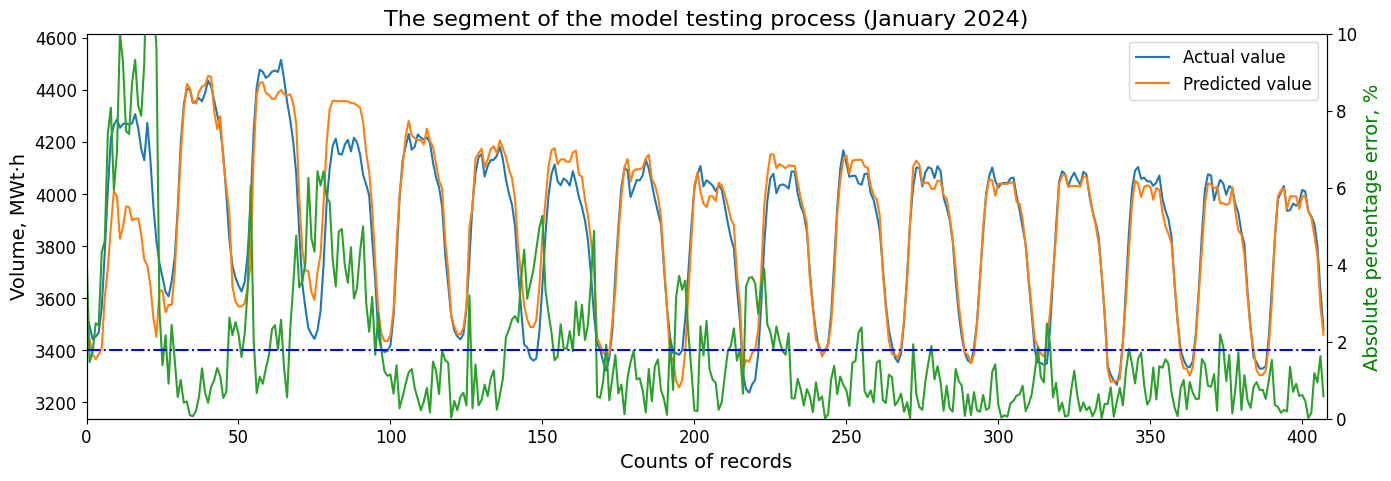

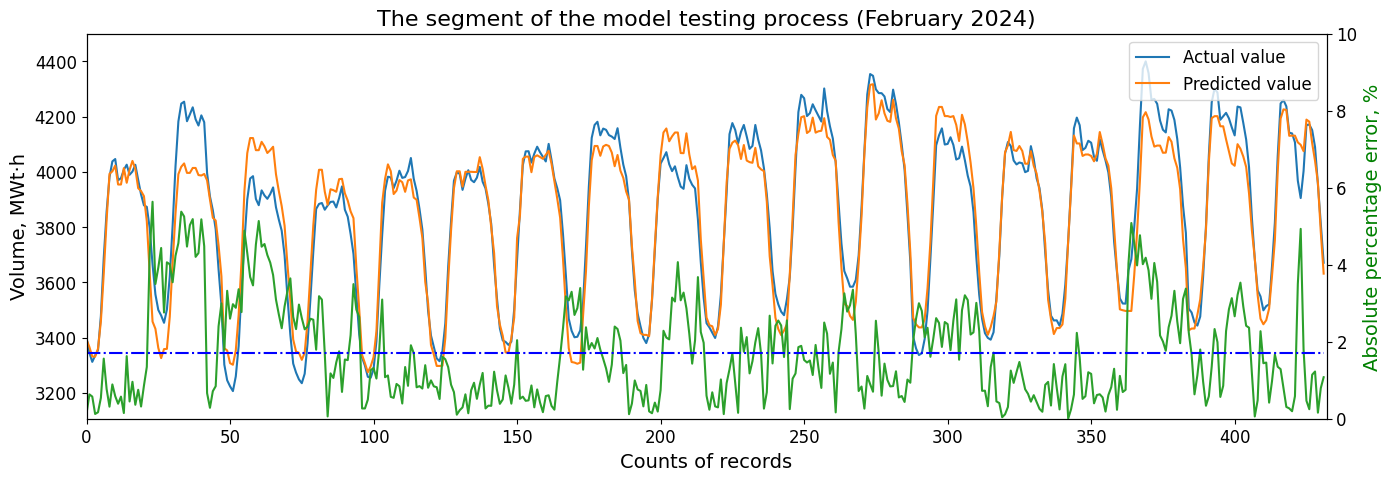

In [76]:
diff_predict_vs_fact(df_validate_result, 1)
diff_predict_vs_fact(df_validate_result, 2)